## Import all the necessary libraries

Source: https://github.com/akshat57/Blind-Descent/blob/main/Blind_Descent-1-CNN.ipynb

In [1]:
import numpy as np
import torch
import sys
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils import data
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.datasets import CIFAR10

import matplotlib.pyplot as plt
import time

from sklearn.metrics import confusion_matrix, classification_report

cuda = torch.cuda.is_available()
cuda = False

## Download the MNIST and CIFAR10 datasets

In [2]:
train = MNIST('./MNIST_data', train=True, download=True, transform=transforms.ToTensor())
test = MNIST('./MNIST_data', train=False, download=True, transform=transforms.ToTensor())
train_MNIST_data = train.data; train_MNIST_labels = train.targets
test_MNIST_data = test.data; test_MNIST_labels = test.targets

train = CIFAR10('./CIFAR10_data', train=True, download=True, transform=transforms.ToTensor())
test = CIFAR10('./CIFAR10_data', train=False, download=True, transform=transforms.ToTensor())
train_CIFAR10_data = train.data; train_CIFAR10_labels = train.targets
test_CIFAR10_data = test.data; test_CIFAR10_labels = test.targets

print()
print("MNIST is already an array")
print(train_MNIST_data.shape, train_MNIST_labels.shape, test_MNIST_data.shape, test_MNIST_labels.shape)
print()
print("CIFAR10 is a list of arrays")
print(len(train_CIFAR10_data), len(train_CIFAR10_labels), len(test_CIFAR10_data), len(test_CIFAR10_labels))
print(train_CIFAR10_data[0].shape, test_CIFAR10_data[0].shape)

Extracting ./MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw


Extracting ./MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw



Extracting ./MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw


Extracting ./MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Extracting ./CIFAR10_data/cifar-10-python.tar.gz to ./CIFAR10_data
Files already downloaded and verified

MNIST is already an array
torch.Size([60000, 28, 28]) torch.Size([60000]) torch.Size([10000, 28, 28]) torch.Size([10000])

CIFAR10 is a list of arrays
50000 50000 10000 10000
(32, 32, 3) (32, 32, 3)


## Dataloader

In [3]:
class CIFAR10Dataset(data.Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.Y)

    def __getitem__(self,index):
        X = np.transpose(self.X[index], (2, 0, 1))
        X = X.astype(float)
        Y = self.Y[index]
        return X,Y

class MNIST_Dataset(data.Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.Y)

    def __getitem__(self,index):
        X = np.pad(self.X[index], 2)
        X = np.repeat(X[:, :, np.newaxis], 3, axis = 2)
        X = np.transpose(X, (2, 0, 1))
        X = X.astype(float)
        Y = self.Y[index]
        return X,Y

Using the torch.utils.data DataLoader, we shuffle the data and set the batch size

In [4]:
num_workers = 8 if cuda else 0 
batch_size = 64
    
# MNIST Training
train_dataset = MNIST_Dataset(train_MNIST_data, train_MNIST_labels)

train_loader_args = dict(shuffle=True, batch_size=batch_size, num_workers=num_workers, pin_memory=True) if cuda\
                    else dict(shuffle=True, batch_size=batch_size)
train_MNIST_loader = data.DataLoader(train_dataset, **train_loader_args)

# MNIST Testing
test_dataset = MNIST_Dataset(test_MNIST_data, test_MNIST_labels)

test_loader_args = dict(shuffle=False, batch_size=batch_size, num_workers=num_workers, pin_memory=True) if cuda\
                    else dict(shuffle=False, batch_size=1)
test_MNIST_loader = data.DataLoader(test_dataset, **test_loader_args)

# CIFAR10 Training
train_dataset = CIFAR10Dataset(train_CIFAR10_data, train_CIFAR10_labels)

train_loader_args = dict(shuffle=True, batch_size=batch_size, num_workers=num_workers, pin_memory=True) if cuda\
                    else dict(shuffle=True, batch_size=batch_size)
train_CIFAR10_loader = data.DataLoader(train_dataset, **train_loader_args)

# CIFAR10 Testing
test_dataset = CIFAR10Dataset(test_CIFAR10_data, test_CIFAR10_labels)

test_loader_args = dict(shuffle=False, batch_size=batch_size, num_workers=num_workers, pin_memory=True) if cuda\
                    else dict(shuffle=False, batch_size=1)
test_CIFAR10_loader = data.DataLoader(test_dataset, **test_loader_args)

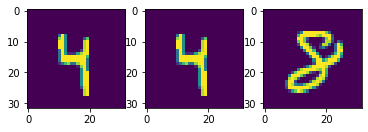

In [5]:
# Visualise MNIST
(data_visualise, _) = next(iter(train_MNIST_loader))
plt.subplot(131)
plt.imshow(data_visualise[0, 0, :, :])
plt.subplot(132)
plt.imshow(data_visualise[0, 1, :, :])
plt.subplot(133)
plt.imshow(data_visualise[1, 0, :, :])

## Define our Neural Network Model 
We define our model using the torch.nn.Module class

In [6]:
class MyCNN_Model(nn.Module):
    def __init__(self):
        super(MyCNN_Model, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size = 5)
        self.pool1 = nn.MaxPool2d(kernel_size = 2)
        self.conv2 = nn.Conv2d(32, 32, kernel_size = 5)
        self.pool2 = nn.MaxPool2d(kernel_size = 2)
        self.conv3 = nn.Conv2d(32, 10, kernel_size = 5)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = x.view(-1, 10)
        
        return x

## Create the model and define the Loss and Optimizer

In [7]:
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda" if cuda else "cpu")
model = MyCNN_Model()
model.to(device)
print(model)

MyCNN_Model(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 10, kernel_size=(5, 5), stride=(1, 1))
)


In [8]:
def zeroMeanUnitUniform(model_new, model, lr):
    conv1weight = model.conv1.weight.detach().cpu().numpy()
    conv2weight = model.conv2.weight.detach().cpu().numpy()
    conv3weight = model.conv3.weight.detach().cpu().numpy()
    model_new.conv1.weight = nn.Parameter(torch.from_numpy(np.random.uniform(-1, 1, conv1weight.shape)).float())
    model_new.conv2.weight = nn.Parameter(torch.from_numpy(np.random.uniform(-1, 1, conv2weight.shape)).float())
    model_new.conv3.weight = nn.Parameter(torch.from_numpy(np.random.uniform(-1, 1, conv3weight.shape)).float())
    return model_new
    
def uniform(model_new, model, lr):
    conv1weight = model.conv1.weight.detach().cpu().numpy()
    conv2weight = model.conv2.weight.detach().cpu().numpy()
    conv3weight = model.conv3.weight.detach().cpu().numpy()
    model_new.conv1.weight = nn.Parameter(torch.from_numpy(np.random.uniform(conv1weight - lr, conv1weight + lr)).float())
    model_new.conv2.weight = nn.Parameter(torch.from_numpy(np.random.uniform(conv2weight - lr, conv2weight + lr)).float())
    model_new.conv3.weight = nn.Parameter(torch.from_numpy(np.random.uniform(conv3weight - lr, conv3weight + lr)).float())
    return model_new
    
def normal(model_new, model, lr):
    model_new.conv1.weight = nn.Parameter(torch.from_numpy(np.random.normal(model.conv1.weight.detach().cpu().numpy(), scale = lr)).float())
    model_new.conv2.weight = nn.Parameter(torch.from_numpy(np.random.normal(model.conv2.weight.detach().cpu().numpy(), scale = lr)).float())
    model_new.conv3.weight = nn.Parameter(torch.from_numpy(np.random.normal(model.conv3.weight.detach().cpu().numpy(), scale = lr)).float())
    return model_new

def randomDistribution(function, model_new, model, lr):
    return function(model_new, model, lr)

In [9]:
def train_epoch(model, train_loader, criterion, epoch, lr, function):
    model.train()

    running_loss = 0.0
    predictions = []
    ground_truth = []
    loss_den = 1
    
    start_time = time.time()
    for batch_idx, (data, target) in enumerate(train_loader):   
        data = data.to(device)
        target = target.to(device)
    
        #previous model
        outputs = model(data.float())
        _, predicted = torch.max(outputs.data, 1)
        total_predictions = target.size(0)
        correct_predictions = (predicted == target).sum().item()
        acc = (correct_predictions/total_predictions)*100.0
        
        loss = criterion(outputs, target)
        
        #new model
        model_new = MyCNN_Model()
        model_new = randomDistribution(function, model_new, model, lr)
        model_new.to(device)
        
        outputs = model_new(data.float())
        _, predicted = torch.max(outputs.data, 1)
        total_predictions = target.size(0)
        correct_predictions = (predicted == target).sum().item()
        acc_new = (correct_predictions/total_predictions)*100.0
        
        loss_new = criterion(outputs, target)

        if loss_new.item() < loss.item():
            loss_den += 1
            running_loss += loss_new.item()
            model = model_new
            #calculuating confusion matrix
            predictions += list(predicted.detach().cpu().numpy())
            ground_truth += list(target.detach().cpu().numpy())
    
    end_time = time.time()

    running_loss /= loss_den
    
    print('Training Loss: ', running_loss, 'Time: ',end_time - start_time, 's')
    
    return running_loss, model

## Create a function that will evaluate our network's performance on the test set

In [10]:
def test_model(model, test_loader, criterion):
    with torch.no_grad():
        model.eval()

        running_loss = 0.0
        total_predictions = 0.0
        correct_predictions = 0.0
        
        predictions = []
        ground_truth = []

        for batch_idx, (data, target) in enumerate(test_loader):   
            data = data.to(device)
            target = target.to(device)

            outputs = model(data.float())

            _, predicted = torch.max(outputs.data, 1)
            total_predictions += target.size(0)
            correct_predictions += (predicted == target).sum().item()

            loss = criterion(outputs, target).detach()
            running_loss += loss.item()
            
            #calculuating confusion matrix
            predictions += list(predicted.detach().cpu().numpy())
            ground_truth += list(target.detach().cpu().numpy())
        
        #write_confusion_matrix('Testing', ground_truth, predictions)
        running_loss /= len(test_loader)
        acc = (correct_predictions/total_predictions)*100.0
        print('Testing Loss: ', running_loss)
        print('Testing Accuracy: ', acc, '%')
        return running_loss, acc


## Train the model for N epochs
We call our training and testing functions in a loop, while keeping track of the losses and accuracy. 

In [11]:
n_epochs = 40
lr = 0.001

model = MyCNN_Model(); model.to(device)
for i in range(n_epochs):
    train_loss, model = train_epoch(model, train_CIFAR10_loader, criterion, i, lr, zeroMeanUnitUniform)
    test_loss, CIFAR10_test_acc_zeroMeanUnitUniform = test_model(model, test_CIFAR10_loader, criterion)
    print('='*20)
    
model = MyCNN_Model(); model.to(device)
for i in range(n_epochs):
    train_loss, model = train_epoch(model, train_CIFAR10_loader, criterion, i, lr, uniform)
    test_loss, CIFAR10_test_acc_uniform = test_model(model, test_CIFAR10_loader, criterion)
    print('='*20)

model = MyCNN_Model(); model.to(device)
for i in range(n_epochs):
    train_loss, model = train_epoch(model, train_CIFAR10_loader, criterion, i, lr, normal)
    test_loss, CIFAR10_test_acc_normal = test_model(model, test_CIFAR10_loader, criterion)
    print('='*20)

model = MyCNN_Model(); model.to(device)
for i in range(n_epochs):
    train_loss, model = train_epoch(model, train_MNIST_loader, criterion, i, lr, zeroMeanUnitUniform)
    test_loss, MNIST_test_acc_zeroMeanUnitUniform = test_model(model, test_MNIST_loader, criterion)

model = MyCNN_Model(); model.to(device)
for i in range(n_epochs):
    train_loss, model = train_epoch(model, train_MNIST_loader, criterion, i, lr, uniform)
    test_loss, MNIST_test_acc_uniform = test_model(model, test_MNIST_loader, criterion)

model = MyCNN_Model(); model.to(device)
for i in range(n_epochs):
    train_loss, model = train_epoch(model, train_MNIST_loader, criterion, i, lr, normal)
    test_loss, MNIST_test_acc_normal = test_model(model, test_MNIST_loader, criterion)

print("CIFAR10_test_acc_zeroMeanUnitUniform", CIFAR10_test_acc_zeroMeanUnitUniform)
print("CIFAR10_test_acc_uniform", CIFAR10_test_acc_uniform)
print("CIFAR10_test_acc_normal", CIFAR10_test_acc_normal)
print("MNIST_test_acc_zeroMeanUnitUniform", MNIST_test_acc_zeroMeanUnitUniform)
print("MNIST_test_acc_uniform", MNIST_test_acc_uniform)
print("MNIST_test_acc_normal", MNIST_test_acc_normal)

Training Loss:  0.0 Time:  40.37845993041992 s
Testing Loss:  66.80088783145204
Testing Accuracy:  9.98 %
Training Loss:  0.0 Time:  40.40077447891235 s
Testing Loss:  66.80088783145204
Testing Accuracy:  9.98 %
Training Loss:  0.0 Time:  40.27223181724548 s
Testing Loss:  66.80088783145204
Testing Accuracy:  9.98 %
Training Loss:  0.0 Time:  40.09716296195984 s
Testing Loss:  66.80088783145204
Testing Accuracy:  9.98 %
Training Loss:  0.0 Time:  40.38274908065796 s
Testing Loss:  66.80088783145204
Testing Accuracy:  9.98 %
Training Loss:  0.0 Time:  40.1335973739624 s
Testing Loss:  66.80088783145204
Testing Accuracy:  9.98 %
Training Loss:  0.0 Time:  40.1544303894043 s
Testing Loss:  66.80088783145204
Testing Accuracy:  9.98 %
Training Loss:  0.0 Time:  40.065733671188354 s
Testing Loss:  66.80088783145204
Testing Accuracy:  9.98 %
Training Loss:  0.0 Time:  40.067301511764526 s
Testing Loss:  66.80088783145204
Testing Accuracy:  9.98 %
Training Loss:  0.0 Time:  40.06388020515442 s